# Prenatal care and death rate

Exploring relationships between prenatal care, infant death rate, and gestational age

In [1]:
import warnings

import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

warnings.filterwarnings('ignore')
my_cmap = cm.get_cmap('tab10')

In [2]:
def filter_values(row):
    if row.isna().any():
        return True
    if 'Unreliable' in row['Death Rate']:
        return True
    if 'Not Applicable' in row['Death Rate']:
        return True
    if float(row['Births']) == 0.0:
        return True
    return False

def get_prenatal(row):
    return row['Month Prenatal Care Began Code'] != 0

prenatal = pd.read_csv('../data/CDC/prenatal.txt', sep='\t')
prenatal.drop(columns=['Notes', 'Year of Death Code'], inplace=True)
prenatal['Drop'] = prenatal.apply(filter_values, axis=1)
prenatal = prenatal[prenatal['Drop'] == False].drop(columns='Drop')
prenatal['Prenatal Care'] = prenatal.apply(get_prenatal, axis=1)
prenatal = prenatal.astype({
    'Month Prenatal Care Began Code': int,
    'Year of Death': int,
    'OE Gestational Age Weekly Code': int,
    'Deaths': int,
    'Births': int,
    'Death Rate': float
})

subset = prenatal[(prenatal['Year of Death'] >= 2016) &
                  (prenatal['OE Gestational Age Weekly Code'] >= 28) &
                  (prenatal['OE Gestational Age Weekly Code'] <= 40)]

## Is there a difference between death rate with or without prenatal care?

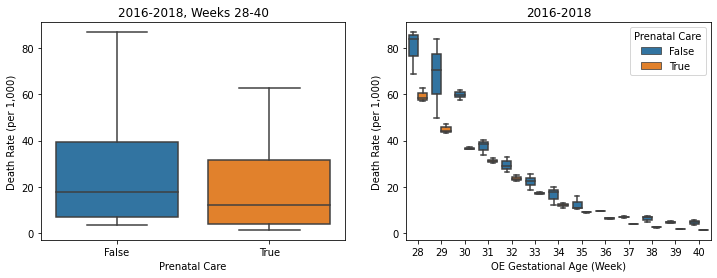

In [3]:
df1 = subset.groupby(['Year of Death', 'OE Gestational Age Weekly Code', 'Prenatal Care'])[['Deaths', 'Births']].sum()
df1['Death Rate'] = df1.apply(lambda row: 1000*row['Deaths']/row['Births'], axis=1)

year_list = []
week_list = []
care_list = []
rate_list = []
log_list = []
for idx, row in df1.iterrows():
    year_list.append(row.name[0])
    week_list.append(row.name[1])
    care_list.append(row.name[2])
    rate_list.append(row['Death Rate'])
    log_list.append(np.log(row['Death Rate']))
df2 = pd.DataFrame(data={
    'Year of Death': year_list,
    'Gestational Week': week_list,
    'Prenatal Care': care_list,
    'Death Rate': rate_list,
    'Log Death Rate': log_list
})

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x='Prenatal Care', y='Death Rate', data=df2, ax=ax[0])
ax[0].set_ylabel('Death Rate (per 1,000)')
ax[0].set_title('2016-2018, Weeks 28-40')

sns.boxplot(x='Gestational Week', y='Death Rate', hue='Prenatal Care', data=df2, ax=ax[1])
ax[1].set_xlabel('OE Gestational Age (Week)')
ax[1].set_ylabel('Death Rate (per 1,000)')
ax[1].set_title('2016-2018');

In [4]:
# Can we add a hypothesis test for the case above? (see case_9.1)
# Can we fit a model to the data by gestational week?
# Can someone interpret the model summaries?

In [5]:
df_f = df2[df2['Prenatal Care'] == False]
model_f = sm.OLS(df_f['Log Death Rate'], sm.add_constant(df_f['Gestational Week']))
res_f = model_f.fit()
print(res_f.summary())

                            OLS Regression Results                            
Dep. Variable:         Log Death Rate   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1187.
Date:                Tue, 12 Oct 2021   Prob (F-statistic):           1.03e-29
Time:                        23:10:39   Log-Likelihood:                 13.326
No. Observations:                  39   AIC:                            -22.65
Df Residuals:                      37   BIC:                            -19.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               11.7041      0.258  

In [6]:
df_t = df2[df2['Prenatal Care'] == True]
model_t = sm.OLS(df_t['Log Death Rate'], sm.add_constant(df_t['Gestational Week']))
res_t = model_t.fit()
print(res_t.summary())

                            OLS Regression Results                            
Dep. Variable:         Log Death Rate   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     2487.
Date:                Tue, 12 Oct 2021   Prob (F-statistic):           1.56e-35
Time:                        23:10:39   Log-Likelihood:                 19.267
No. Observations:                  39   AIC:                            -34.53
Df Residuals:                      37   BIC:                            -31.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.3574      0.222  

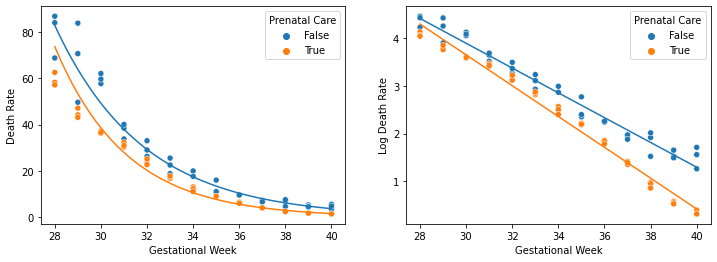

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(x='Gestational Week', y='Death Rate', hue='Prenatal Care', data=df2, ax=ax[0])
sns.scatterplot(x='Gestational Week', y='Log Death Rate', hue='Prenatal Care', data=df2, ax=ax[1])

x = np.linspace(28, 40)
y_f = np.polyval([res_f.params[1], res_f.params[0]], x)
ax[0].plot(x, np.exp(y_f))
ax[1].plot(x, y_f)

y_t = np.polyval([res_t.params[1], res_t.params[0]], x)
ax[0].plot(x, np.exp(y_t))
ax[1].plot(x, y_t);

## Does the month you start prenatal care matter?

In [8]:
# Linear model
df = subset[subset['Prenatal Care'] == True]
df['Log Death Rate'] = df.apply(lambda row: np.log(row['Death Rate']), axis=1)
model_ls = sm.OLS(df['Log Death Rate'], sm.add_constant(df[['OE Gestational Age Weekly Code', 'Month Prenatal Care Began Code']]))
res_ls = model_ls.fit()
print(res_ls.summary())

                            OLS Regression Results                            
Dep. Variable:         Log Death Rate   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     3188.
Date:                Tue, 12 Oct 2021   Prob (F-statistic):          4.13e-185
Time:                        23:10:39   Log-Likelihood:                 10.646
No. Observations:                 266   AIC:                            -15.29
Df Residuals:                     263   BIC:                            -4.542
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

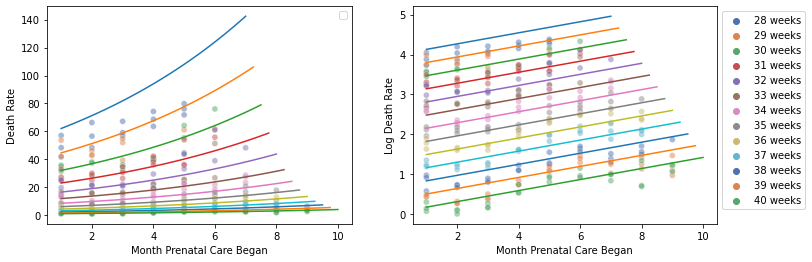

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(x='Month Prenatal Care Began Code', y='Death Rate', hue='OE Gestational Age Weekly',
                palette='deep', data=df, ax=ax[0], alpha=0.5)
sns.scatterplot(x='Month Prenatal Care Began Code', y='Log Death Rate', hue='OE Gestational Age Weekly',
                palette='deep', data=df, ax=ax[1], alpha=0.5)

for week in df['OE Gestational Age Weekly Code'].unique():
    x = np.linspace(1, week/4)
    y = res_ls.params[0] + res_ls.params[1]*week + res_ls.params[2]*x
    ax[0].plot(x, np.exp(y))
    ax[1].plot(x, y)
    
ax[0].set_xlabel('Month Prenatal Care Began')
ax[1].set_xlabel('Month Prenatal Care Began')
ax[0].legend('')
ax[1].legend(bbox_to_anchor=(1, 1));

In [10]:
# Mixed-effects model
model_me = sm.MixedLM(df['Log Death Rate'].values,                 # dependent variable
                      df['Month Prenatal Care Began Code'].values, # fixed effects covariates
                      df['OE Gestational Age Weekly Code'].values) # groups
res_me = model_me.fit()
print(res_me.summary())

# Note: Similar coefficient as before, but different offsets

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y      
No. Observations: 266     Method:             REML   
No. Groups:       13      Scale:              0.0337 
Min. group size:  13      Log-Likelihood:     16.9258
Max. group size:  27      Converged:          Yes    
Mean group size:  20.5                               
-----------------------------------------------------
            Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
x1          0.139    0.005 26.021 0.000  0.129  0.150
Group Var   5.505   12.063                           



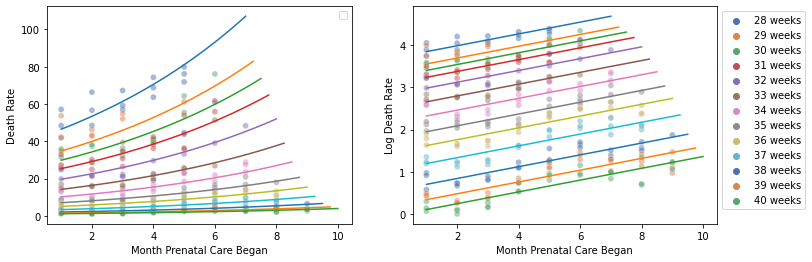

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(x='Month Prenatal Care Began Code', y='Death Rate', hue='OE Gestational Age Weekly',
                palette='deep', data=df, ax=ax[0], alpha=0.5)
sns.scatterplot(x='Month Prenatal Care Began Code', y='Log Death Rate', hue='OE Gestational Age Weekly',
                palette='deep', data=df, ax=ax[1], alpha=0.5)

for week in df['OE Gestational Age Weekly Code'].unique():
    x = np.linspace(1, week/4)
    y = res_me.random_effects[week][0] + res_me.params[0]*x
    ax[0].plot(x, np.exp(y))
    ax[1].plot(x, y)
    
ax[0].set_xlabel('Month Prenatal Care Began')
ax[1].set_xlabel('Month Prenatal Care Began')
ax[0].legend('')
ax[1].legend(bbox_to_anchor=(1, 1));